In [12]:
from mss import mss
import pydirectinput
import cv2
import numpy as np
import pytesseract
pytesseract.pytesseract.tesseract_cmd = r'C:/Program Files/Tesseract-OCR/tesseract.exe'
from matplotlib import pyplot as plt
import time
from gym import Env
from gym.spaces import Box, Discrete

Game Enviornment

In [13]:
class gamerl(Env):
    def __init__(self):
        super().__init__()
        self.observation_space = Box(low=0, high=255, shape=(1,83,100), dtype=np.uint8)
        self.action_space=Discrete(3)
        
        self.cap = mss()
        self.game_location = {'top': 260, 'left': 560, 'width': 250, 'height': 175}
        self.done_location = {'top': 280, 'left': 820, 'width': 260, 'height': 30}
    
    def step(self,action):
        pass
    
    def get_observation(self):
        raw = np.array(self.cap.grab(self.game_location))[:,:,:3].astype(np.uint8)
        gray = cv2.cvtColor(raw, cv2.COLOR_BGR2GRAY)
        resized = cv2.resize(gray, (100,83))
        channel = np.reshape(resized, (1,83,100))
        return channel
    
    def get_done(self):
        done_cap = np.array(self.cap.grab(self.done_location))
        done_strings = ['GAME', 'GAHE']
        done=False
        res = pytesseract.image_to_string(done_cap)[:4]
        if res in done_strings:
            done = True
        return done, done_cap
    
    def step(self, action):
        action_map = {
            0:'space',
            1: 'down', 
            2: 'no_op'
        }
        if action !=2:
            pydirectinput.press(action_map[action])

        done, done_cap = self.get_done() 
        observation = self.get_observation()
        reward = 1 
        info = {}
        return observation, reward, done, info
    
    def reset(self):
        time.sleep(1)
        pydirectinput.click(x=150, y=150)
        pydirectinput.press('space')
        return self.get_observation()
        
    def render(self):
        cv2.imshow('Game', np.array(self.cap.grab(self.game_location))[:,:,:3])
        if cv2.waitKey(1) & 0xFF == ord('q'):
            self.close()
         
    def close(self):
        cv2.destroyAllWindows()

Testing the definations

In [14]:
env=gamerl() 

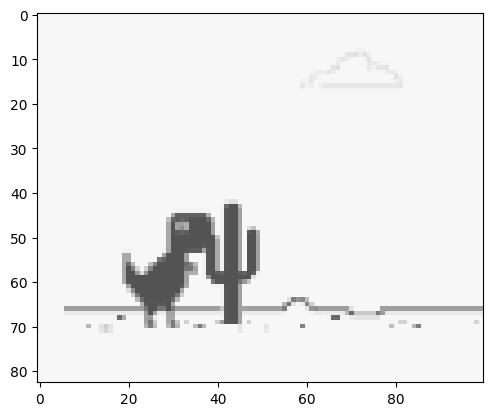

In [15]:
plt.imshow(cv2.cvtColor(env.get_observation()[0], cv2.COLOR_GRAY2BGR))

In [16]:
env.action_space.sample()

1

In [ ]:
plt.imshow(np.array(env.get_done()))

In [27]:
env.render()

In [24]:
env.close()

In [ ]:
env.reset()

array([[[247, 247, 247, ..., 247, 247, 247],
        [247, 247, 247, ..., 247, 247, 247],
        [247, 247, 247, ..., 247, 247, 247],
        ...,
        [247, 247, 247, ..., 247, 247, 247],
        [247, 247, 247, ..., 247, 247, 247],
        [247, 247, 247, ..., 247, 247, 247]]], dtype=uint8)

In [ ]:
for episode in range(10): 
    obs = env.reset()
    done = False  
    total_reward   = 0
    while not done: 
        obs, reward,  done, info =  env.step(env.action_space.sample())
        total_reward  += reward
    print('Total Reward for episode {} is {}'.format(episode, total_reward)) 

Training

In [20]:
import os 
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common import env_checker

In [22]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [23]:
CHECKPOINT_DIR = './train/'
LOG_DIR = './logs/'

In [24]:
callback = TrainAndLoggingCallback(check_freq=1000, save_path=CHECKPOINT_DIR)

DQN

In [25]:
from stable_baselines3 import DQN
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, VecFrameStack

In [26]:
env = gamerl()

In [36]:
model = DQN('CnnPolicy', env, tensorboard_log=LOG_DIR, verbose=1, buffer_size=24000, learning_starts=1000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


d:\anaconda\envs\dino\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


In [ ]:
model.learn(total_timesteps=100000, callback=callback)

Testing the model

In [ ]:
model.load('./best_model/best_model_88000') 

In [ ]:
for episode in range(5): 
    obs = env.reset()
    done = False
    total_reward = 0
    while not done: 
        action, _ = model.predict(obs)
        obs, reward, done, info = env.step(int(action))
        time.sleep(0.01)
        total_reward += reward
    print('Total Reward for episode {} is {}'.format(episode, total_reward))
    time.sleep(2)